In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

2023-01-02 13:31:13.771847: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-02 13:31:13.771892: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-02 13:31:19.772246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-02 13:31:19.772551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-02 13:31:19.772624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
         "datasets",
          shuffle=True,
          image_size=(IMAGE_SIZE,IMAGE_SIZE),
          batch_size=BATCH_SIZE
)

Found 4490 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

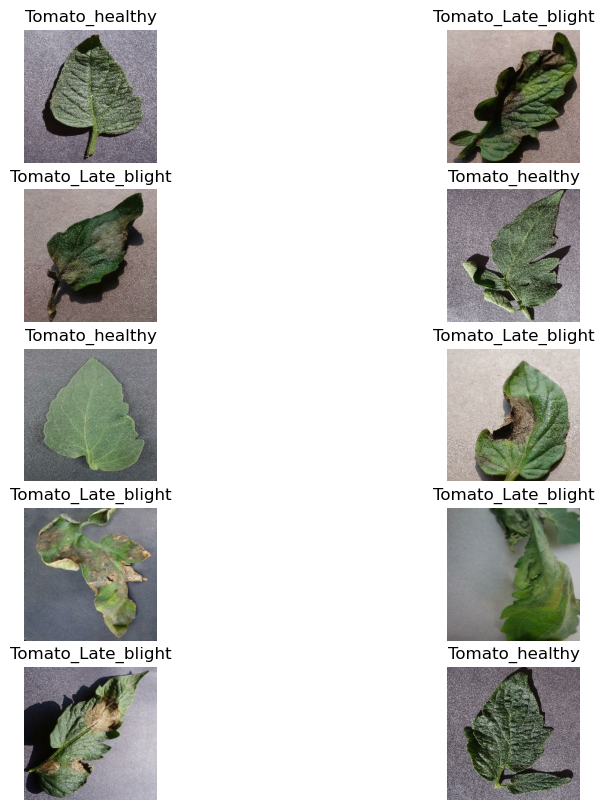

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        
    

In [7]:
#80% TRAINING
#20% ---> 10% validation after each epochs and 10% test
len(dataset)   #total batch holo 141 ta 

141

In [8]:
# ei 141 ta batch er 80% 112 ta batch
train_ds = dataset.take(112)
len(train_ds)

112

In [9]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [10]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [11]:
test_ds = test_ds.skip(10)
len(test_ds)

19

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    #assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(val_ds)

14

# cache shuffle and prefetch the dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
112/112 [==============================] - 200s 2s/step - loss: 0.9002 - accuracy: 0.5432 - val_loss: 0.9326 - val_accuracy: 0.4777
Epoch 2/50
112/112 [==============================] - 149s 1s/step - loss: 0.6638 - accuracy: 0.7021 - val_loss: 0.6441 - val_accuracy: 0.7478
Epoch 3/50
112/112 [==============================] - 147s 1s/step - loss: 0.4141 - accuracy: 0.8296 - val_loss: 0.3816 - val_accuracy: 0.8214
Epoch 4/50
112/112 [==============================] - 161s 1s/step - loss: 0.3244 - accuracy: 0.8669 - val_loss: 0.9105 - val_accuracy: 0.6853
Epoch 5/50
112/112 [==============================] - 193s 2s/step - loss: 0.3349 - accuracy: 0.8641 - val_loss: 0.2953 - val_accuracy: 0.8817
Epoch 6/50
112/112 [==============================] - 165s 1s/step - loss: 0.2536 - accuracy: 0.8919 - val_loss: 0.3634 - val_accuracy: 0.8460
Epoch 7/50
112/112 [==============================] - 159s 1s/step - loss: 0.2590 - accuracy: 0.8942 - val_loss: 0.2368 - val_accuracy: 0.9040

112/112 [==============================] - 134s 1s/step - loss: 0.0405 - accuracy: 0.9857 - val_loss: 0.1310 - val_accuracy: 0.9464
Epoch 42/50
112/112 [==============================] - 130s 1s/step - loss: 0.0504 - accuracy: 0.9801 - val_loss: 0.2412 - val_accuracy: 0.9286
Epoch 43/50
112/112 [==============================] - 9181s 83s/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.0828 - val_accuracy: 0.9710
Epoch 44/50
112/112 [==============================] - 215s 2s/step - loss: 0.0383 - accuracy: 0.9848 - val_loss: 0.2430 - val_accuracy: 0.9263
Epoch 45/50
112/112 [==============================] - 193s 2s/step - loss: 0.0487 - accuracy: 0.9809 - val_loss: 0.2452 - val_accuracy: 0.9196
Epoch 46/50
112/112 [==============================] - 169s 2s/step - loss: 0.0766 - accuracy: 0.9742 - val_loss: 0.1480 - val_accuracy: 0.9397
Epoch 47/50
112/112 [==============================] - 164s 1s/step - loss: 0.0349 - accuracy: 0.9854 - val_loss: 0.1090 - val_accuracy: 0.9554
Ep

In [23]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 3s 200ms/step - loss: 0.1244 - accuracy: 0.9500


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

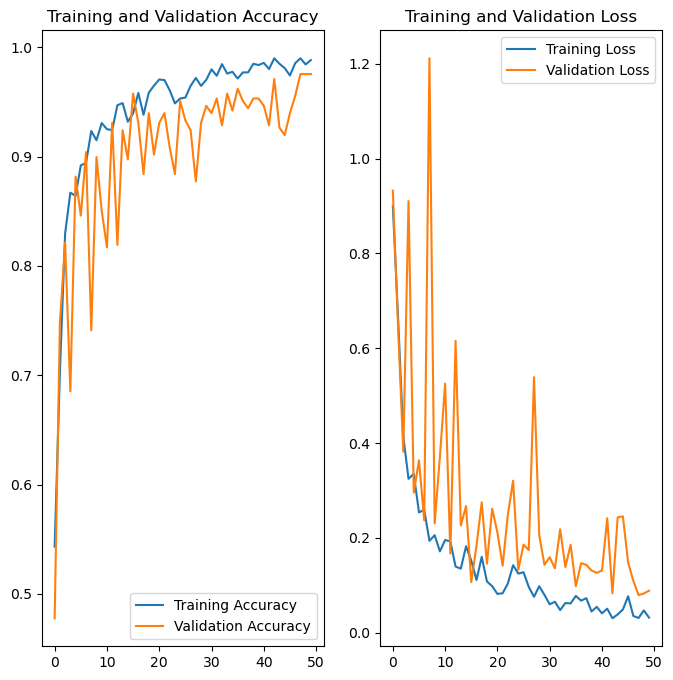

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 505ms/step
predicted label: Tomato_healthy


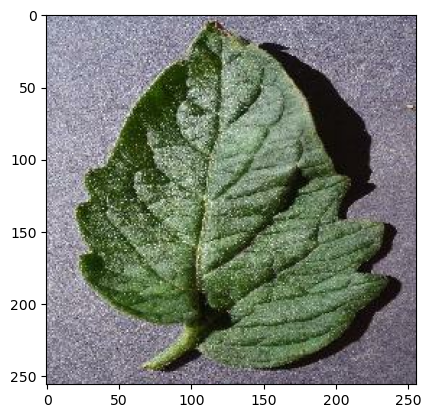

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Writing a function for the inference

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


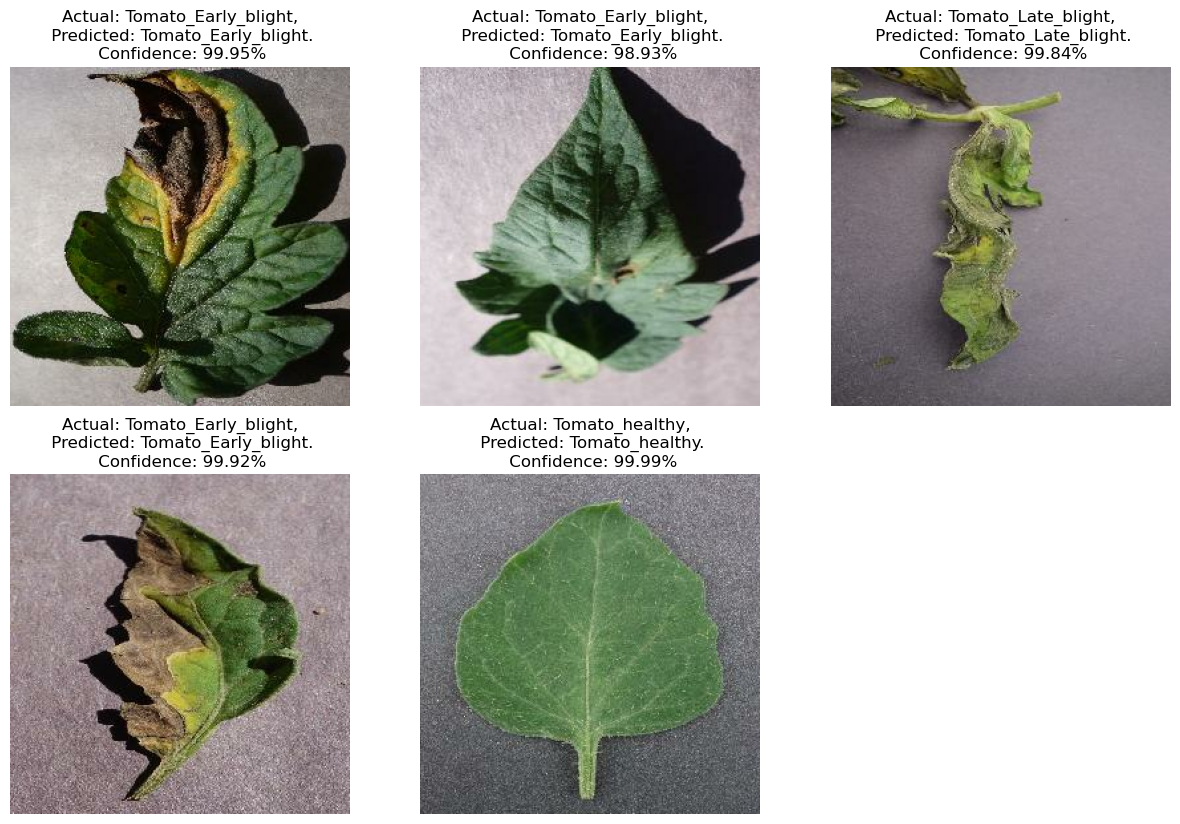

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(5):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
model.save("0.0.1")

INFO:tensorflow:Assets written to: 0.0.1\assets


INFO:tensorflow:Assets written to: 0.0.1\assets
